<a href="https://colab.research.google.com/github/juan-holguin/TAM_2025_2/blob/main/Tller_parcial/Taller_parcial_juan_holguin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import fetch_california_housing

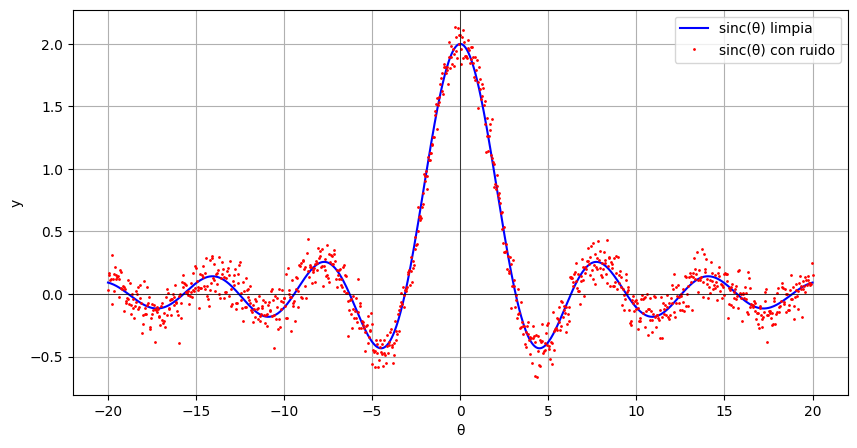

In [8]:
# Definición de sinc con amplitud A
def sinc(theta, A=1.0):
    return np.where(theta == 0, A, A * np.sin(theta)/theta)

# Parámetros
A = 2.0            # amplitud
sigma = 0.1        # desviación estándar del ruido
theta = np.linspace(-20, 20, 1000)

# Señal sinc pura
y_clean = sinc(theta, A)

# Señal con ruido gaussiano
noise = np.random.normal(0, sigma, size=theta.shape)
y_noisy = y_clean + noise

# Graficar
plt.figure(figsize=(10,5))
plt.plot(theta, y_clean, 'b', label="sinc(θ) limpia")
plt.plot(theta, y_noisy, 'r.', markersize=2, label="sinc(θ) con ruido")
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel("θ")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()



In [9]:
# ============================
# PDF 2D (para prior/posterior)
# ============================
def my_2Dpdf(mu, Sigma, axes, cmap='Reds', xlim=[-3,3], ylim=[-3,3]):
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(mu, Sigma)
    Z = rv.pdf(pos)
    axes.contourf(X, Y, Z, cmap=cmap)
    axes.set_xlim(xlim); axes.set_ylim(ylim)

# ============================
# Muestreo de funciones lineales
# ============================
def my_linregsyn(mu, Sigma, axes, xlim=[-20,20], ylim=[-3,3], nsamples=5):
    X = np.linspace(xlim[0], xlim[1], 200)
    samples = np.random.multivariate_normal(mu, Sigma, nsamples)
    for w in samples:
        y = w[0] + w[1]*X
        axes.plot(X, y, 'b')
    axes.set_xlim(xlim); axes.set_ylim(ylim)

# ============================
# Posterior bayesiano (lineal)
# ============================
def my_posterior_update(X, t, sigma, sig_w, tol=1e-10):
    # X: entradas, t: salidas
    Phi = np.hstack([np.ones((X.shape[0],1)), X])   # diseño (bias + X)
    S0 = sig_w * np.eye(Phi.shape[1])
    Sn_inv = np.linalg.inv(S0) + (1/sigma**2) * Phi.T @ Phi
    Sn = np.linalg.inv(Sn_inv)
    mn = Sn @ ((1/sigma**2) * Phi.T @ t)
    return mn, Sn

# ============================
# Predictiva
# ============================
def my_predictiva_update(X, mN, SN, sigma):
    Phi = np.hstack([np.ones((X.shape[0],1)), X])
    mean = Phi @ mN
    var = np.sum(Phi @ SN * Phi, axis=1) + sigma**2
    return mean, np.sqrt(var)

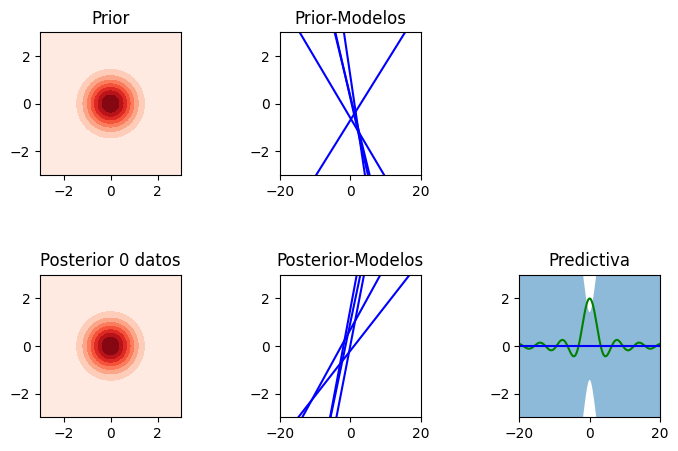

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# ============================
# Definición de sinc con amplitud A
# ============================
def sinc(theta, A=1.0):
    return np.where(theta == 0, A, A * np.sin(theta)/theta)

# ============================
# Parámetros de la señal
# ============================
A = 2.0          # amplitud
sigma = 0.1      # desviación estándar del ruido
N = 500          # número de muestras

# ============================
# Variable de entrada (X = θ)
# ============================
theta = np.linspace(-20, 20, N).reshape(-1,1)

# Señal sinc limpia
tt = sinc(theta.ravel(), A)

# Señal observada con ruido
t = tt + np.random.normal(0, sigma, N)

# Formato correcto para la regresión Bayesiana
X = theta

# ============================
# Inicialización Bayesiana
# ============================
ind = np.random.randint(0, X.shape[0], size=X.shape[0])
mu_w = np.array([0,0])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

# límites gráficos
wxlim = [-3,3]
wylim = [-3,3]
xlim = [-20,20]
ylim = [-3,3]

# ============================
# Funciones auxiliares (debes tenerlas definidas en tu notebook):
#   my_2Dpdf
#   my_linregsyn
#   my_posterior_update
#   my_predictiva_update
# ============================

# figura y axes animación
fig, ax = plt.subplots(2, 3, figsize=(8,5))
ax[0,2].axis('off')

# función de actualización para la animación
def update(i):
    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()
    ax[1,2].clear()

    # prior
    my_2Dpdf(mu_w, S_w, axes=ax[0,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0,1], xlim=xlim, ylim=ylim)

    # posterior con i datos
    mN, SN = my_posterior_update(X[ind[:i]], t[ind[:i]], sigma, sig_w, tol=1e-10)
    my_2Dpdf(mN, SN, axes=ax[1,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1,1], xlim=xlim, ylim=ylim)
    ax[1,1].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')

    # graficar predictiva
    mnew, snew = my_predictiva_update(X, mN, SN, sigma)
    ax[1,2].plot(X[:,0], tt, c='g', label="sinc real")
    ax[1,2].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')
    ax[1,2].plot(X[:,0], mnew, c='b', label="predictiva")
    ii = np.argsort(X[:,0])
    ax[1,2].fill_between(X[ii,0].ravel(),
                         mnew[ii].ravel() - 2*snew[ii],
                         mnew[ii].ravel() + 2*snew[ii],
                         alpha=0.5)

    ax[1,2].set_xlim(xlim)
    ax[1,2].set_ylim(ylim)

    # títulos
    ax[0,0].set_title('Prior')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title('Posterior ' + str(i) + ' datos')
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7, hspace=0.7)

# desplegar animación
anim = animation.FuncAnimation(
    fig, update, frames=np.array([0,1,2,3,5,7,9,10,15,20,25,50,100,250,499]),
    blit=False
)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# División 70% train, 30% test
X_train, X_test, t_train, t_test = train_test_split(
    X, t, test_size=0.3, random_state=42
)

In [13]:
# Entrenamiento (posterior en train)
mN, SN = my_posterior_update(X_train, t_train, sigma, sig_w) # calcula la distribucion posterior

# Predictiva en train
m_train, s_train = my_predictiva_update(X_train, mN, SN, sigma) #calcula distribucion predictiva

# Predictiva en test
m_test, s_test = my_predictiva_update(X_test, mN, SN, sigma)#ahora usamos los datos de prueba

In [14]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(t_train, m_train))
rmse_test = np.sqrt(mean_squared_error(t_test, m_test))

print(f"RMSE Train: {rmse_train:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")

RMSE Train: 0.5468
RMSE Test: 0.5085


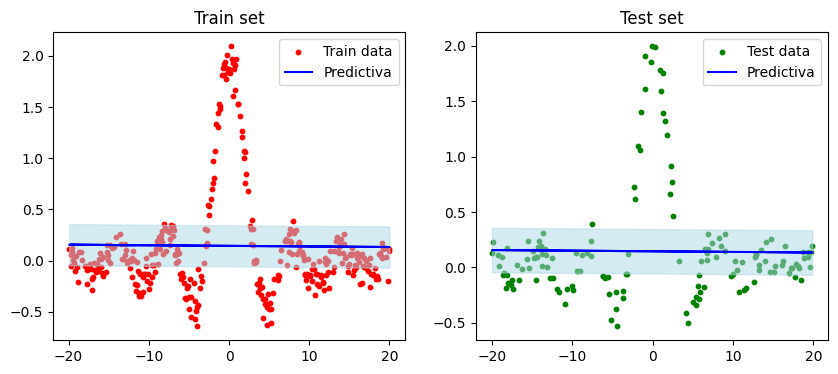

In [15]:
# Gráfico train
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(X_train, t_train, c="r", s=10, label="Train data")
plt.plot(X_train, m_train, "b", label="Predictiva")
ii = np.argsort(X_train[:,0])
plt.fill_between(X_train[ii,0].ravel(),
                 m_train[ii]-2*s_train[ii],
                 m_train[ii]+2*s_train[ii],
                 color="lightblue", alpha=0.5)
plt.title("Train set")
plt.legend()

# Gráfico test
plt.subplot(1,2,2)
plt.scatter(X_test, t_test, c="g", s=10, label="Test data")
plt.plot(X_test, m_test, "b", label="Predictiva")
ii = np.argsort(X_test[:,0])
plt.fill_between(X_test[ii,0].ravel(),
                 m_test[ii]-2*s_test[ii],
                 m_test[ii]+2*s_test[ii],
                 color="lightblue", alpha=0.5)
plt.title("Test set")
plt.legend()

plt.show()

# **Solucion por polinomios para la no linealidad**

0


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=5.69789e-43): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


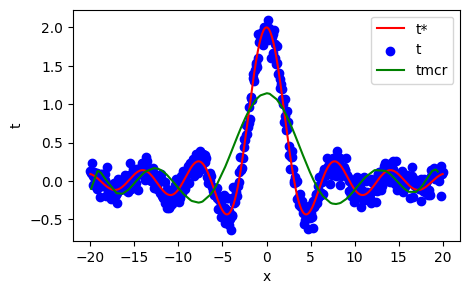

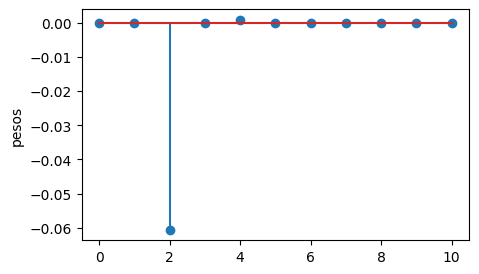

In [18]:
#solución min cuadrados regularizados
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import ShuffleSplit


#generación representación polinomial
#desde la libreria sklearn
Q = 10 #grado del polinomio
phiQ = PolynomialFeatures(degree=Q)
Phi = phiQ.fit_transform(X)#representar datos desde polinomio

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.2)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


#regresor
lambdaR = 1e-15#hiperparámetro de regularización
reg_mc = Ridge(alpha=lambdaR)

train_i = np.sort(train_i)
test_i = np.sort(test_i)

reg_mc.fit(Phi[train_i],t[train_i])

t_mc = reg_mc.predict(Phi[test_i])

plt.figure(figsize=(5,3))
plt.plot(X,tt,c='r',label='t*')
plt.scatter(X,t,c='b',label='t')
plt.plot(X[test_i],t_mc,c='g',label='tmcr')

plt.legend()
plt.xlabel('x')
plt.ylabel('t')
plt.show()

plt.figure(figsize=(5,3))
plt.stem(reg_mc.coef_)
plt.ylabel('pesos')
plt.show()

In [13]:
# Dataset California housing
data = fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names
print("Features:", feature_names)
print("X shape:", X.shape, "y shape:", y.shape)


Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X shape: (20640, 8) y shape: (20640,)
